## PART A: Recurrent Neural Network & Classification: 



### 1) Data Processing

a) Import the following libraries: 

In [1]:
import sys
import os
import json
import optparse

import pandas as pd
import numpy as np
import tensorflow as tf

import keras
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Embedding, Input, Bidirectional
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict

import matplotlib.pyplot as plt
from typing import Tuple


b) We will read the code in slightly differently than before: 

In [2]:
dataframe = pd.read_csv("../data/dev-access.csv", engine='python', quotechar='|', header=None)

c) We then need to convert to a numpy.ndarray type: 

In [3]:
dataset = dataframe.values

d) Check the shape of the data set - it should be (26773, 2). Spend some time looking at the data. 

e) Store all rows and the 0th index as the feature data: 

In [4]:
X = dataset[:,0]

f) Store all rows and index 1 as the target variable: 

In [5]:
Y = dataset[:,1]

g) In the next step, we will clean up the predictors. This includes removing features that are not valuable, such as timestamp and source. 

In [6]:
for index, item in enumerate(X):
    # Quick hack to space out json elements
    reqJson = json.loads(item, object_pairs_hook=OrderedDict)
    del reqJson['timestamp']
    del reqJson['headers']
    del reqJson['source']
    del reqJson['route']
    del reqJson['responsePayload']
    X[index] = json.dumps(reqJson, separators=(',', ':'))

h) We next will tokenize our data, which just means vectorizing our text. Given the data we will tokenize every character (thus char_level = True)

In [7]:
tokenizer = Tokenizer(filters='\t\n', char_level=True)
tokenizer.fit_on_texts(X)

# we will need this later
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)

i) Need to pad our data as each observation has a different length

In [8]:
max_log_length = 1024
X_processed = sequence.pad_sequences(X, maxlen=max_log_length)

j) Create your train set to be 75% of the data and your test set to be 25%

In [9]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_processed, Y, test_size=0.25, random_state=42)

# Check the shape of the train and test sets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (20079, 1024)
Y_train shape: (20079,)
X_test shape: (6694, 1024)
Y_test shape: (6694,)


### 2) Model 1 - RNN

a) Start by creating an instance of a Sequential model

In [10]:
model = Sequential()

b) From there, add an Embedding layer,

Params:
- input_dim = num_words 
- output_dim = 32
- input_length = max_log_length 
- Keep all other variables as the defaults 

In [11]:
model.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_log_length))

c) Add a SimpleRNN layer

Params:
- units = 32
- activation = 'relu'

In [12]:
from keras.layers import SimpleRNN

model.add(SimpleRNN(units=32, activation='relu'))

d) Finally, we will add a Dense layer

Params:
- units = 1 (this will be our output)
- activation --> you can choose to use either relu or sigmoid. 

In [13]:
model.add(Dense(units=1, activation='sigmoid'))

e) Compile model using the .compile() method

Params:
- loss = binary_crossentropy
- optimizer = adam
- metrics = accuracy

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

f) Print the model summary

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1024, 32)          2016      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________


g) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [16]:
# convert the NumPy array to a tensor
Y_train_tensor = tf.convert_to_tensor(Y_train, dtype=tf.int32)


In [17]:
model.fit(X_train, Y_train_tensor, validation_split=0.25, epochs=3, batch_size=128)

Epoch 1/3
118/118 [==============================] - 86s 713ms/step - loss: 0.5980 - accuracy: 0.6681 - val_loss: 0.6356 - val_accuracy: 0.6361
Epoch 2/3
118/118 [==============================] - 85s 721ms/step - loss: 0.5990 - accuracy: 0.6471 - val_loss: 0.5768 - val_accuracy: 0.6590
Epoch 3/3
118/118 [==============================] - 85s 720ms/step - loss: 0.3093 - accuracy: 0.8716 - val_loss: 0.1507 - val_accuracy: 0.9600


h) Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [18]:
Y_test_tensor = tf.convert_to_tensor(Y_test, dtype=tf.int32)

loss, accuracy = model.evaluate(X_test, Y_test_tensor, batch_size=128)
print(f"Test loss: {round(loss*100,2)}%")
print(f"Test accuracy: {round(accuracy*100,2)}%")

53/53 [==============================] - 5s 92ms/step - loss: 0.1451 - accuracy: 0.9633
Test loss: 14.51%
Test accuracy: 96.33%


### 3) Model 2 - LSTM + Dropout Layers

a) This RNN needs to have the following layers (add in this order):

- Embedding Layer (use same params as before)
- LSTM Layer (units = 64, recurrent_dropout = 0.5)
- Dropout Layer - use a value of 0.5
- Dense Layer - (use same params as before)


In [19]:
model2 = Sequential()
model2.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_log_length))
model2.add(LSTM(units=64, recurrent_dropout=0.5))
model2.add(Dropout(0.5))
model2.add(Dense(units=1, activation='sigmoid'))

b) Compile model using the .compile() method:

Params:
- loss = binary_crossentropy
- optimizer = adam
- metrics = accuracy

In [20]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

c) Print the model summary

In [21]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1024, 32)          2016      
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________
None


d) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [22]:
model2.fit(X_train, Y_train_tensor, validation_split=0.25, epochs=3, batch_size=128)

Epoch 1/3
118/118 [==============================] - 369s 3s/step - loss: 0.5037 - accuracy: 0.7296 - val_loss: 0.1623 - val_accuracy: 0.9486
Epoch 2/3
118/118 [==============================] - 367s 3s/step - loss: 0.1261 - accuracy: 0.9659 - val_loss: 0.0981 - val_accuracy: 0.9653
Epoch 3/3
118/118 [==============================] - 367s 3s/step - loss: 0.0900 - accuracy: 0.9758 - val_loss: 0.0830 - val_accuracy: 0.9817


e) Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [23]:
loss, accuracy = model2.evaluate(X_test, Y_test_tensor, batch_size=128)
print(f"Test loss: {round(loss*100,2)}%")
print(f"Test accuracy: {round(accuracy*100,2)}%")

53/53 [==============================] - 18s 337ms/step - loss: 0.0725 - accuracy: 0.9839
Test loss: 7.25%
Test accuracy: 98.39%


### Conceptual Questions: 

<i>5) Explain the difference between the relu activation function and the sigmoid activation function.</i>

The activation function is an important component of a neural network that is used to introduce non-linearity into the output of each neuron. The two most commonly used activation functions are the Rectified Linear Unit (ReLU) and the sigmoid function.

The ReLU function (Rectified Linear Unit) is a simple, non-linear activation function that returns the input if it is positive, and 0 if it is negative. This means that the output is always non-negative and the function is very computationally efficient. ReLU is known to work well in deep neural networks and is the most commonly used activation function in neural networks today.

On the other hand, the sigmoid function is a smooth, S-shaped function that maps any input to a value between 0 and 1. The sigmoid function is commonly used in binary classification problems as it is able to produce an output that can be interpreted as a probability of belonging to a particular class. The sigmoid function is also used in recurrent neural networks, where it is used to introduce non-linearity into the output of each neuron.

<br>

<i>6) Describe what one epoch actually is (epoch was a parameter used in the .fit() method).</i>

In machine learning, an epoch refers to the number of times the entire training dataset is presented to the model during the training process. When we train a model, we pass the training data through the model, compute the loss, adjust the model parameters, and repeat this process multiple times until the loss is minimized or the accuracy is maximized. This repetition is done for a fixed number of iterations, which is referred to as an epoch.

Choosing the number of epochs is a balance between underfitting (too few epochs) and overfitting (too many epochs). If the model is underfitting, the error on the training set will be high, and the model may benefit from additional epochs. On the other hand, if the model is overfitting, the error on the validation set will be high, and the model may need to be regularized or stopped earlier to avoid overfitting.

<br>

<i>7) Explain how dropout works (you can look at the keras code and/or documentation) for (a) training, and (b) test data sets.</i>

Dropout is a regularization technique used to prevent overfitting in neural networks. During training, dropout randomly sets a fraction of the neurons in a layer to zero, which helps prevent the network from relying too heavily on any one feature, and encourages the network to learn more robust representations of the input data.

During training, dropout works by randomly setting a fraction of the output values of a layer to zero at each update of the network weights. The fraction of the neurons to be dropped out is usually specified as a hyperparameter and typically ranges between 0.1 and 0.5. The effect of dropout during training is similar to training a large number of neural networks with different architectures, which can help prevent overfitting.

During inference, the network is no longer being trained and the full network is used to make predictions. Since dropout is only applied during training, it is turned off during inference. However, the output values of each neuron in the network are multiplied by the fraction of the neurons that were not dropped out during training. This is done to ensure that the output values during inference have the same statistical properties as they did during training.

<br>

<i>8) Explain why problems such as this homework assignment are better modeled with RNNs than CNNs. What type of problem will CNNs outperform RNNs on?</i>

RNNs are better suited for sequential data such as time series, natural language, and speech recognition tasks, as they can process data in a sequential order and capture temporal dependencies. In contrast, CNNs are better suited for image and video data, where local spatial patterns are important. CNNs can perform well in problems where the data has a fixed size, and the local structure is important, such as image classification, object detection, and segmentation tasks.

In this homework assignment, we are working with time series data, where the order of the input sequence matters, and each data point is dependent on the previous data point(s). RNNs are well-suited for these types of problems because they can capture the temporal dependencies and long-term patterns in the data.

CNNs, on the other hand, are better suited for tasks that involve local spatial patterns such as image classification. For example, in image classification tasks, the local spatial patterns within an image are important for identifying the object in the image. In this case, the order of the pixels within an image is not as important as the spatial patterns within the image.

<br>

<i>9) Explain what RNN problem is solved using LSTM and briefly describe how.</i>

One of the main problems with traditional RNNs is the vanishing gradient problem, where gradients become too small during backpropagation and can cause the model to have difficulty learning long-term dependencies. LSTM (Long Short-Term Memory) is a type of RNN architecture that solves this problem by using a gating mechanism to control the flow of information through the network. It does this by introducing three gates (input, forget, and output) that control the flow of information through the network, allowing the model to selectively remember or forget information from previous time steps. This gating mechanism makes LSTM well-suited for modeling time series data with long-term dependencies.

<br>

### 4) Recurrent Neural Net Model 3


a) RNN Requirements:
- Use 5 or more layers
- Add a layer that was not utilized in Model 1 or Model 2 (Note: This could be a new Dense layer or an additional LSTM)

In [24]:
inputs = Input(shape=(max_log_length,))
x = Embedding(input_dim=num_words, output_dim=32, input_length=max_log_length)(inputs)
x = LSTM(units=64, recurrent_dropout=0.5, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = LSTM(units=64, recurrent_dropout=0.5, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = LSTM(units=64, recurrent_dropout=0.5)(x)
x = Dense(units=1, activation='sigmoid')(x)

model3 = Model(inputs=inputs, outputs=x)

b) Compiler Requirements:
- Try a new optimizer for the compile step
- Keep accuracy as a metric 

In [25]:
from keras.optimizers import RMSprop

model3.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

c) Print the model summary

In [26]:
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 1024, 32)          2016      
                                                                 
 lstm_1 (LSTM)               (None, 1024, 64)          24832     
                                                                 
 dropout_1 (Dropout)         (None, 1024, 64)          0         
                                                                 
 lstm_2 (LSTM)               (None, 1024, 64)          33024     
                                                                 
 dropout_2 (Dropout)         (None, 1024, 64)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024 

d) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [27]:
history = model3.fit(X_train, Y_train_tensor, validation_split=0.25, epochs=3, batch_size=128)

Epoch 1/3
118/118 [==============================] - 1117s 9s/step - loss: 0.4014 - accuracy: 0.8118 - val_loss: 0.1939 - val_accuracy: 0.9376
Epoch 2/3
118/118 [==============================] - 1124s 10s/step - loss: 0.1890 - accuracy: 0.9399 - val_loss: 0.0841 - val_accuracy: 0.9739
Epoch 3/3
118/118 [==============================] - 1160s 10s/step - loss: 0.1279 - accuracy: 0.9623 - val_loss: 0.0625 - val_accuracy: 0.9805


e) Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [28]:
loss, accuracy = model3.evaluate(X_test, Y_test_tensor, batch_size=128)
print(f"Test loss: {round(loss*100,2)}%")
print(f"Test accuracy: {round(accuracy*100,2)}%")

53/53 [==============================] - 53s 991ms/step - loss: 0.0684 - accuracy: 0.9779
Test loss: 6.84%
Test accuracy: 97.79%


##PART B: Time Series with LSTMs

* Import, clean and plot the input data
* Train test split (use provided helper function helper.py)
* Fit a single layer LSTM with lag = 3 hours
* Fit a single layer LSTM with lag = 24 hours
* Fit a bidirectional LSTM with lag = 24 hours
* Plot results on test set and compare performance using RMSE

In [29]:
# helper function
def create_data_for_NN(data: pd.DataFrame, Y_var: str, lag: int, test_ratio: float) -> Tuple[np.array, np.array, np.array, np.array]:
  """Function to return lagged time series data after train-test split
  Args:
  data (pd.DataFrame): Raw time series data frame
  Y_var (str): String with the name of y variable
  lag (int): number of lagged records to consider
  test_ratio (float): ratio of data to consider for test set
  Returns:
  Tuple[np.array, np.array, np.array, np.array]: Lagged and split numpy
  arrays
  """
  y = data[Y_var].tolist()
  X, Y = [], []
  if len(y) - lag <= 0:
    X.append(y)
  else:
    for i in range(len(y) - lag):
      Y.append(y[i + lag])
      X.append(y[i : (i + lag)])
  X, Y = np.array(X), np.array(Y)
  # Reshaping the X array to an LSTM input shape
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  # Creating training and test sets
  X_train = X
  X_test = []
  Y_train = Y
  Y_test = []
  if test_ratio > 0:
    index = round(len(X) * test_ratio)
  X_train = X[: (len(X) - index)]
  X_test = X[-index:]
  Y_train = Y[: (len(X) - index)]
  Y_test = Y[-index:]
  
  return X_train, X_test, Y_train, Y_test


In [31]:
# Load and preprocess data
data = pd.read_csv("../data/DAYTON_hourly.csv")
data.Datetime = pd.to_datetime(data.Datetime)
data.sort_values(by="Datetime", inplace=True)

# Define lag and test ratio
lag_3 = 3
lag_24 = 24
test_ratio = 0.15

# Split the data using the helper function
X_train_3, X_test_3, Y_train_3, Y_test_3 = create_data_for_NN(data, data.columns[-1], lag_3, test_ratio)
X_train_24, X_test_24, Y_train_24, Y_test_24 = create_data_for_NN(data, data.columns[-1], lag_24, test_ratio)

# Single layer LSTM with lag 3
model_3 = Sequential()
model_3.add(LSTM(64, input_shape=(X_train_3.shape[1], X_train_3.shape[2])))
model_3.add(Dense(1))
model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])
history_3 = model_3.fit(X_train_3, Y_train_3, epochs=10, batch_size=128, validation_split=0.25)

# Single layer LSTM with lag 24
model_24 = Sequential()
model_24.add(LSTM(64, input_shape=(X_train_24.shape[1], X_train_24.shape[2])))
model_24.add(Dense(1))
model_24.compile(loss='mse', optimizer='adam', metrics=['mae'])
history_24 = model_24.fit(X_train_24, Y_train_24, epochs=10, batch_size=128, validation_split=0.25)

# Bidirectional LSTM with lag 24
model_bidir = Sequential()
model_bidir.add(Bidirectional(LSTM(64, input_shape=(X_train_24.shape[1], X_train_24.shape[2]))))
model_bidir.add(Dense(1))
model_bidir.compile(loss='mse', optimizer='adam', metrics=['mae'])
history_bidir = model_bidir.fit(X_train_24, Y_train_24, epochs=10, batch_size=128, validation_split=0.25)

# Make predictions and calculate RMSE for each model
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

pred_3 = model_3.predict(X_test_3)
rmse_3 = rmse(pred_3, Y_test_3)
print("RMSE for single layer LSTM with lag 3: ", rmse_3)

pred_24 = model_24.predict(X_test_24)
rmse_24 = rmse(pred_24, Y_test_24)
print("RMSE for single layer LSTM with lag 24: ", rmse_24)

pred_bidir = model_bidir.predict(X_test_24)
rmse_bidir = rmse(pred_bidir, Y_test_24)
print("RMSE for bidirectional LSTM with lag 24: ", rmse_bidir)


Epoch 1/10
604/604 [==============================] - 5s 4ms/step - loss: 4361788.5000 - mae: 2049.6169 - val_loss: 4054992.2500 - val_mae: 1979.2885
Epoch 2/10
604/604 [==============================] - 2s 3ms/step - loss: 4315917.0000 - mae: 2038.4037 - val_loss: 4010844.0000 - val_mae: 1968.1013
Epoch 3/10
604/604 [==============================] - 2s 3ms/step - loss: 4270499.5000 - mae: 2027.2311 - val_loss: 3967042.2500 - val_mae: 1956.9446
Epoch 4/10
604/604 [==============================] - 2s 3ms/step - loss: 4223671.0000 - mae: 2015.6527 - val_loss: 3921235.2500 - val_mae: 1945.2023
Epoch 5/10
604/604 [==============================] - 2s 3ms/step - loss: 4177833.0000 - mae: 2004.2493 - val_loss: 3877294.2500 - val_mae: 1933.8801
Epoch 6/10
604/604 [==============================] - 2s 3ms/step - loss: 4132639.5000 - mae: 1992.9429 - val_loss: 3833747.5000 - val_mae: 1922.5845
Epoch 7/10
604/604 [==============================] - 2s 3ms/step - loss: 4087804.7500 - mae: 1981.6

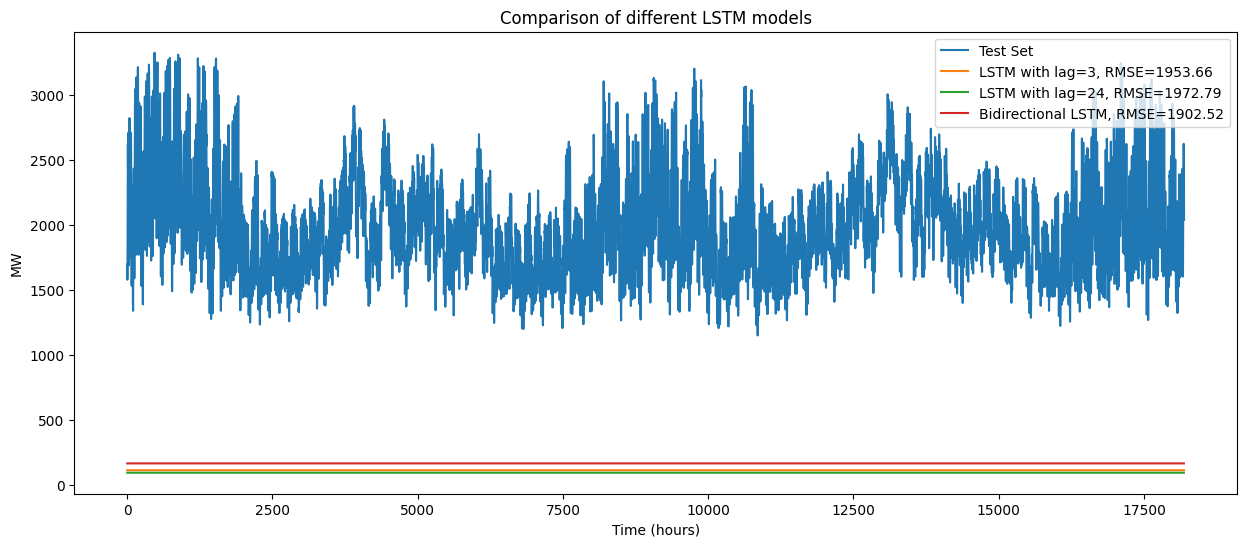

In [32]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test_3, label="Test Set")
plt.plot(pred_3, label="LSTM with lag=3, RMSE={:.2f}".format(rmse_3))
plt.plot(pred_24, label="LSTM with lag=24, RMSE={:.2f}".format(rmse_24))
plt.plot(pred_bidir, label="Bidirectional LSTM, RMSE={:.2f}".format(rmse_bidir))
plt.legend()
plt.xlabel("Time (hours)")
plt.ylabel("MW")
plt.title("Comparison of different LSTM models")
plt.show()